In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from sklearn.neighbors import KernelDensity

# Initial analysis of Apple quotes
When searching for Apple quotes, we must discard food-related quotes while including quotes about Apple Inc. Therefore, we will use a rule-based approach, where we have a list of indicator words that decide whether to include a quotation. This way, we will be left with a filtered dataset containing mostly quotations related to the company Apple. This also enables us to utilize more extensive filtration algorithms, which would be too costly to run on the entire dataset. We have created a data preprocessing pipeline, which as a result has created a csv-file for each year, consisting only of Apple-related quotes.

Let's first load this data, as well as the relevant dates of the Apple product launches.


In [2]:
df = pd.read_csv("data/quotes-2020-apple-filter.csv",sep=";")
df = df.append(pd.read_csv("data/quotes-2019-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2018-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2017-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2016-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2015-apple-filter.csv",sep=";"))

#List of dates for the apple events
apple_event_dates_str=["2015-03-09","2015-06-10","2015-09-09",
"2016-03-21","2016-06-15","2016-09-07", "2016-10-27",
"2017-06-07", "2017-09-12",
"2018-03-27","2018-06-06", "2018-09-12", "2018-10-30",
"2019-03-25","2019-06-05","2019-09-10","2019-12-02",
"2020-06-24","2020-09-15","2020-10-13","2020-11-10"]

#apple_event_dates_pd = pd.DataFrame({'Date':[dt.datetime.strptime(date, "%Y-%m-%d").date() for date in apple_event_dates_str]})
apple_event_dates=[dt.datetime.strptime(date, "%Y-%m-%d").date() for date in apple_event_dates_str]

In [3]:
df

,quoteID,quotation,speaker,date,numOccurrences
0,2020-03-29-000118,... Zane Lowe checks in via FaceTime with Elto...,None,2020-03-29 17:47:52,1
1,2020-02-13-007205,Apple prices generally peak in January. Betwee...,Sarah Johnson,2020-02-13 10:01:48,3
2,2020-01-23-044076,"I'm not sure why Apple did this,",Roger Grimes,2020-01-23 17:15:24,2
3,2020-01-02-039024,new multi-year license agreement under which A...,None,2020-01-02 09:56:04,3
4,2020-01-19-037883,the best sort of deal they could have come up ...,Dickie Arbiter,2020-01-19 19:24:59,1
...,...,...,...,...,...
21483,2015-10-02-101639,"This is a mindset for permanent growth, becaus...",Terry Bell,2015-10-02 03:12:52,5
21484,2015-01-29-102007,We estimate [ that the pace of iPhone upgrades...,Andy Hargreaves,2015-01-29 17:52:13,3
21485,2015-05-18-003700,Apple has a world-class recycling program.,Tim Cook,2015-05-18 15:08:25,3
21486,2015-09-09-009615,"At the same time, those who purchase four pack...",Jason Teoh,2015-09-09 23:40:41,1


As seen above, we have gathered approximately 90.000 quotes from the quotebank data through 2015 to 2020. Lets start by investigating how the quote occurrences vary throughout the year

## How does the daily number of quotes vary throughout the year?

In [4]:
# Clean the date column, such that it only contains date information and not timestamp
df['date_clean'] = df.apply(lambda x: x['date'][:10],axis=1)

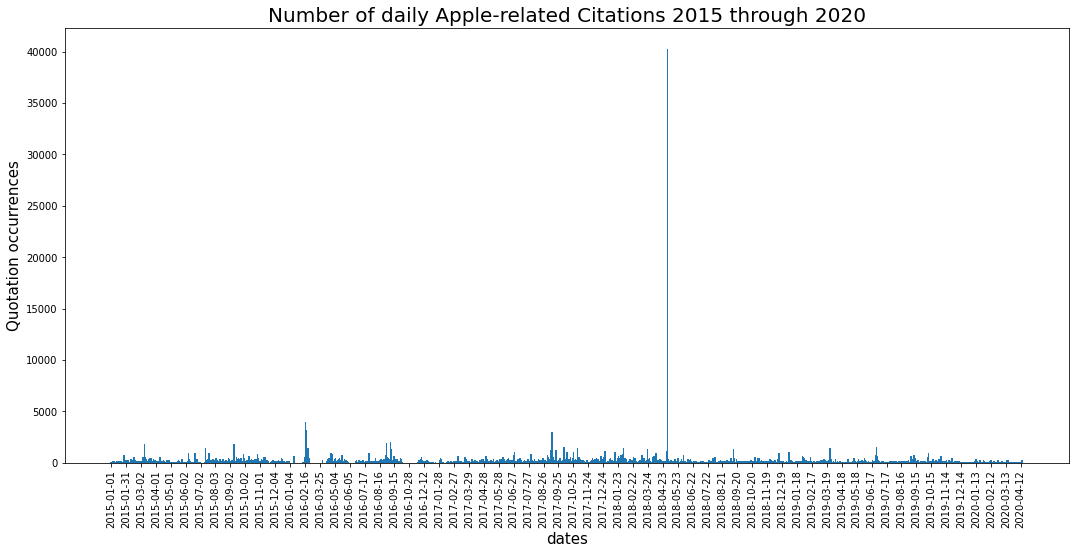

In [5]:
# Create plot to see the Apple-related quotes through the years
time = df.groupby(['date_clean']).sum().index
quote_num = df.groupby(['date_clean']).sum()['numOccurrences']
fig,ax = plt.subplots(figsize=(18,8))
ax.bar(time,quote_num,width=3, align='center')
ax.set_xlabel("dates",size=15)
plt.xticks(time[::30],rotation=90)
ax.set_ylabel("Quotation occurrences",size=15)
ax.set_title("Number of daily Apple-related Citations 2015 through 2020",size=20)
plt.show()

We see a massive spike close to the date 2018-04-23, which seems rather suspicious. Let's investigate this further, by finding the particular quote and print its information.

In [6]:
# Print info about outlier quote
print(f"Quote occurrences: {df.loc[df.numOccurrences == df.numOccurrences.max()].numOccurrences.item()} ")
print(f"Quote: {df.loc[df.numOccurrences == df.numOccurrences.max()].quotation.item()}")

Quote occurrences: 39978 
Quote: Fortnite for iPhone is something of a gem in terms of content and its free-to-play structure.


It seems unlikely that such a generic quote has such a high occurrence number. There is the possibility that the quote originates from a viral tweet or advertisement, however, googling the quote yields no results. We will thus regard this as an extreme outlier for now, and investigate it further by comparing to the original data set in Milestone 3. 

In [7]:
# Drop outlier
df = df.drop(df.loc[df.numOccurrences == 39978].index)

Now that the outlier has been dropped, let's take a look at the plot again. 

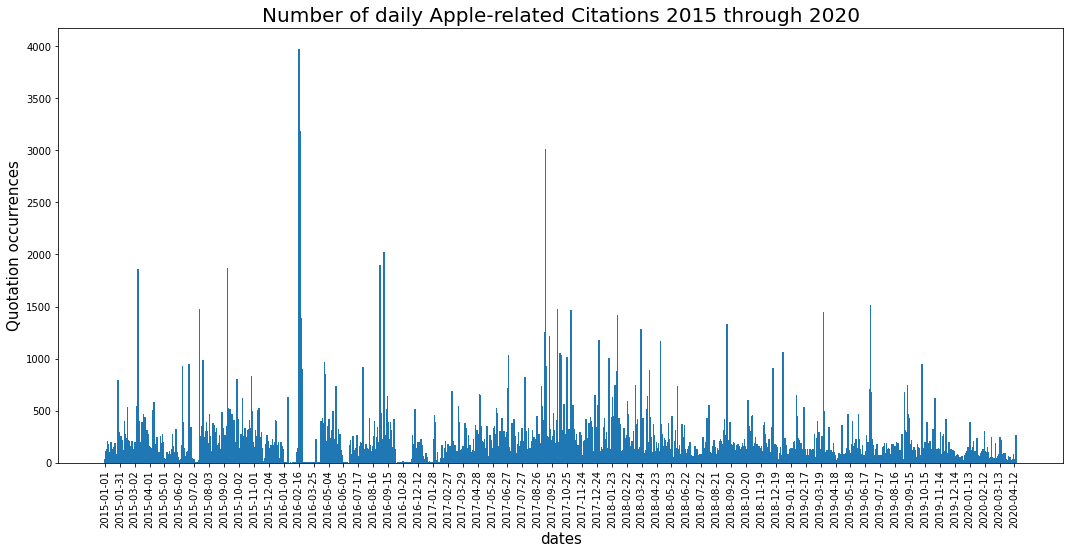

In [8]:
# Create plot to see the Apple-related quotes through the years (without outlier)
time = df.groupby(['date_clean']).sum().index
quote_num = df.groupby(['date_clean']).sum()['numOccurrences']
fig,ax = plt.subplots(figsize=(18,8))
ax.bar(time,quote_num,width=3, align='center')
ax.set_xlabel("dates",size=15)
plt.xticks(time[::30],rotation=90)
ax.set_ylabel("Quotation occurrences",size=15)
ax.set_title("Number of daily Apple-related Citations 2015 through 2020",size=20)
plt.show()

This looks more reasonable. Let's try to look if any of the peaks occur at the same time as apple events

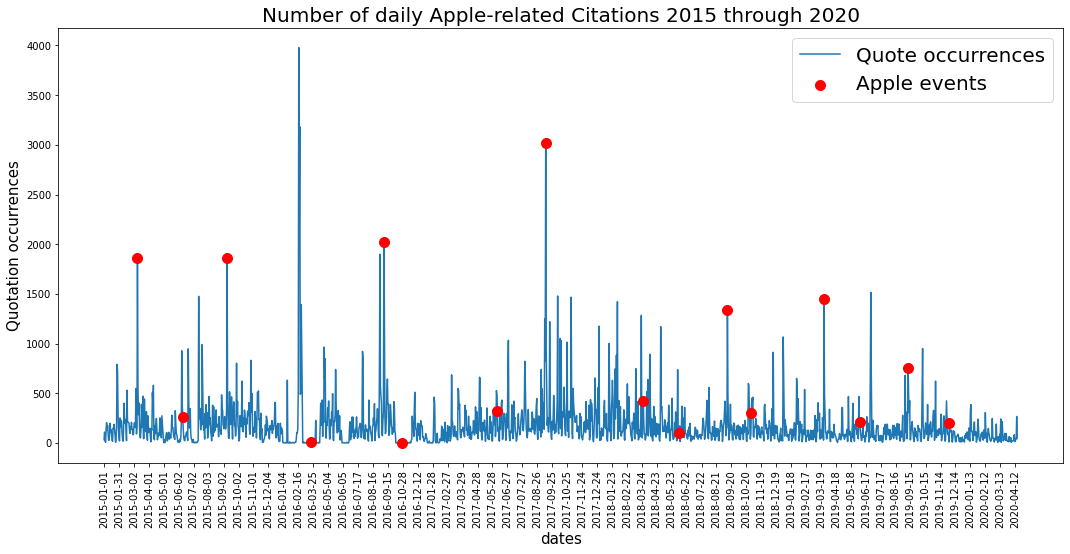

In [9]:
# add apple product launches as points
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(time,quote_num, label= "Quote occurrences")
ax.set_xlabel("dates",size=15)
ax.scatter(time[time.isin(apple_event_dates_str)],quote_num[time.isin(apple_event_dates_str)], c="r", s=100, zorder=3, label='Apple events')
plt.xticks(time[::30],rotation=90)
ax.set_ylabel("Quotation occurrences",size=15)
ax.set_title("Number of daily Apple-related Citations 2015 through 2020",size=20)
ax.legend(prop={'size': 20})
plt.show()


Many of the peaks are very close to Apple product launches. In Milestone 3 we will investigate this further.

## 3. How does the distribution of quote occurences look?

We will now take a quick glance at how the distribution of Apple quotes look.

Text(0.5, 1.0, 'Distribution of quote occurrences (Occurrences capped at 60)')

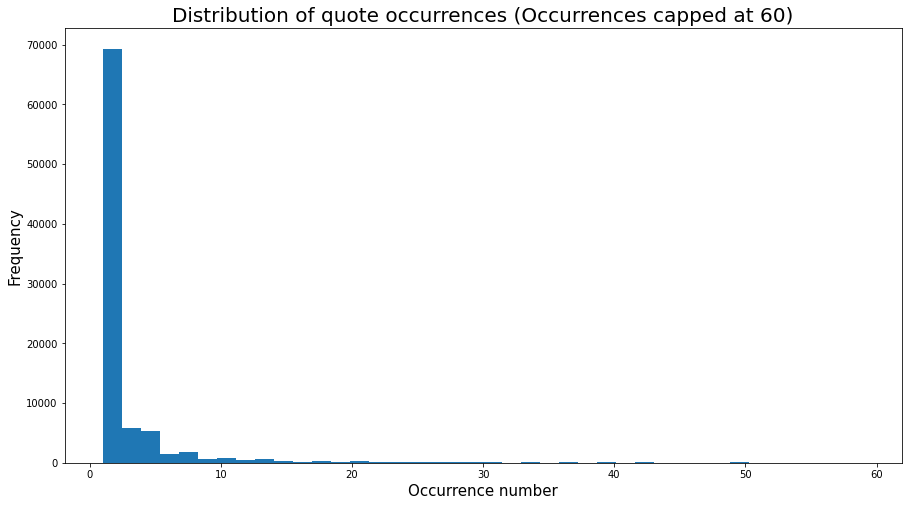

In [10]:
fig,ax = plt.subplots(figsize=(15,8))
ax.hist(df.numOccurrences[df.numOccurrences < 60],bins=40,);
ax.set_xlabel("Occurrence number",size=15)
ax.set_ylabel("Frequency",size=15)
ax.set_title("Distribution of quote occurrences (Occurrences capped at 60)",size=20)


As seen above, most of the quotes have been cited less than 10 times.

## 4. How does the most frequent speakers vary throughout the year?

### Investigation of frequent speakers

We will now investigate which speakers are the most cited when it comes to Apple. 


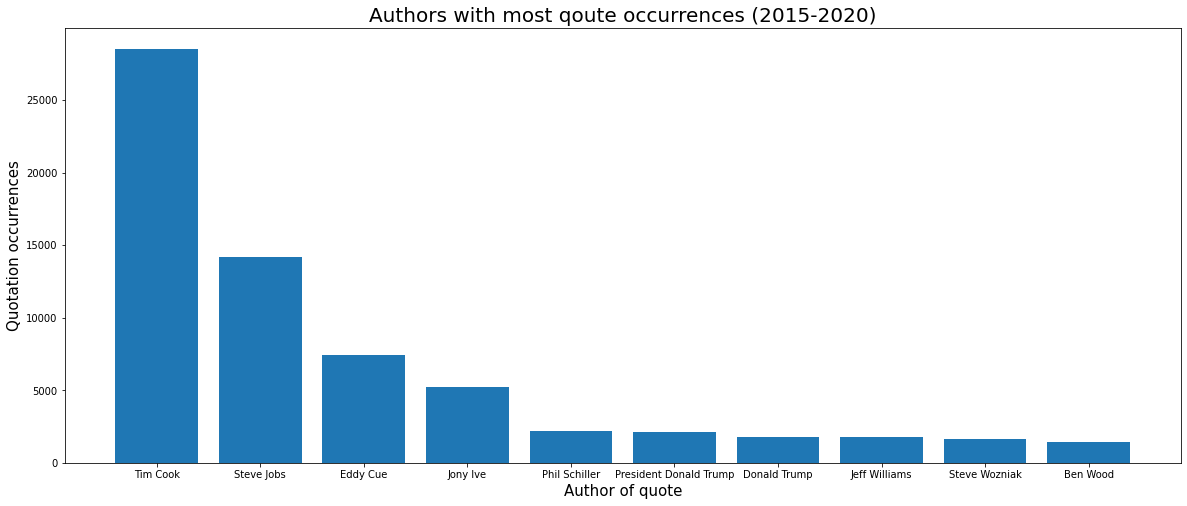

In [11]:
top_speakers = df.loc[df.speaker != 'None'].groupby(by=['speaker']).sum().sort_values(by='numOccurrences',ascending=False).reset_index()
fig,ax = plt.subplots(figsize=(20,8))
ax.bar(top_speakers.speaker[:10],top_speakers.numOccurrences[:10])
ax.set_xlabel("Author of quote",size=15)
ax.set_ylabel("Quotation occurrences",size=15)
#plt.xticks(top_speakers.speaker1[:10],rotation=90)
ax.set_title("Authors with most qoute occurrences (2015-2020)",size=20)
plt.show()

We see that Apple-related staff has the most quotes related to Apple e.g. Tim Cook, Steve Jobs, Eddy Cue, Jony Ive and Steve Wozniak. We now want to portray how this has evolved throughout the years. We will do this by making a column for each speaker. This enables us to plot the most active speakers over the period. Note that Donald Trump has several entries. The the code below will fix this as well.

In [12]:
#Extracting dataset and formatting date
quotes_per_date = df.copy()
quotes_per_date['date'] = quotes_per_date['date'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d'))

#Extracting dataset and formatting date to show only month
quotes_per_month = df.copy()
quotes_per_month['date'] = quotes_per_month['date'].apply(lambda x: dt.datetime.strptime(x[:7], '%Y-%m'))

#Pivoting table such that each column is a speaker and index is date
#Merging Donald Trump quotations and dropping None as well
quotes_per_date = quotes_per_date.pivot_table('numOccurrences', ['date'], 'speaker', fill_value=0, aggfunc=np.sum)
quotes_per_date['Donald Trump'] = quotes_per_date['Donald Trump'] + \
                                  quotes_per_date['President Donald Trump'] + \
                                  quotes_per_date['President Trump']
quotes_per_date.drop(['None', 'President Donald Trump', 'President Trump'], axis=1, inplace=True)

quotes_per_month = quotes_per_month.pivot_table('numOccurrences', ['date'], 'speaker', fill_value=0, aggfunc=np.sum)
quotes_per_month['Donald Trump'] = quotes_per_month['Donald Trump'] + \
                                   quotes_per_month['President Donald Trump'] + \
                                   quotes_per_month['President Trump']
quotes_per_month.drop(['None', 'President Donald Trump', 'President Trump'], axis=1, inplace=True)

#Cummulative representation of quotes
cummulative_quotes_per_date = quotes_per_date.cumsum(axis=0)
cummulative_quotes_per_month = quotes_per_month.cumsum(axis=0)

Due to visibility reasons we have chosen to only display the three most active speakers. 

Text(0, 0.5, 'Number of quotations')

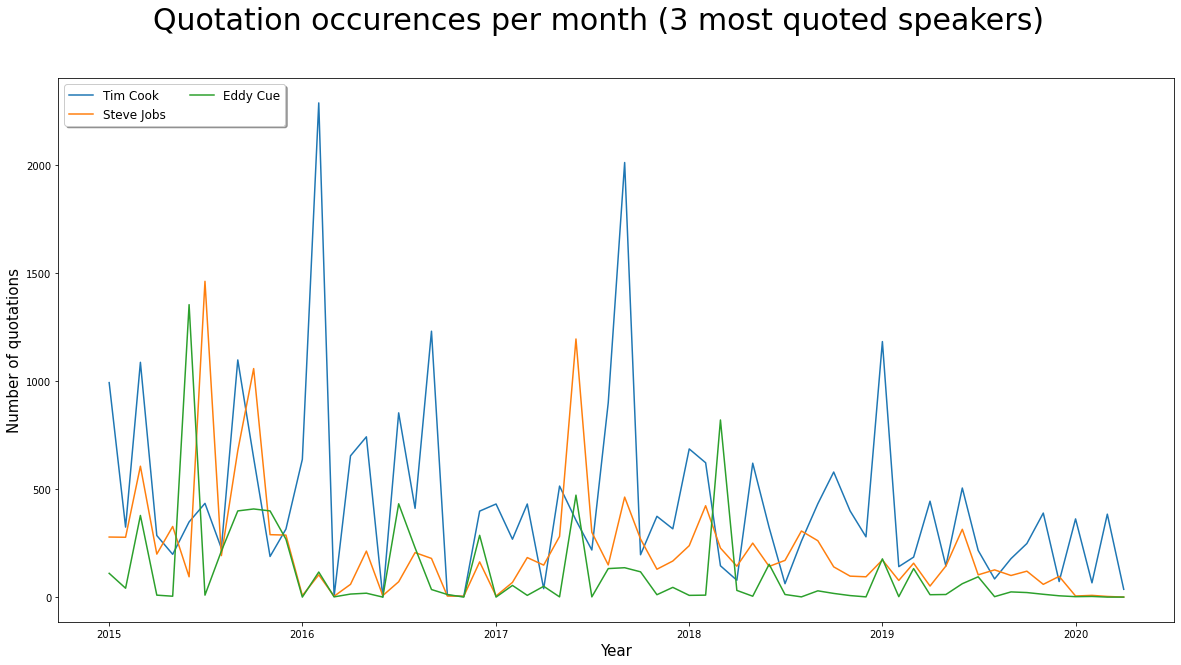

In [13]:
#Extract the 3 most frequent speakers
top_quoters = quotes_per_month.sum(axis=0).nlargest(3).index

#Extracting these from week dataset
top_quotes_per_month = quotes_per_month[top_quoters]
cummulative_top_quotes_per_month = cummulative_quotes_per_month[top_quoters]

fig = plt.figure(figsize=(20, 10))
labels=[]
for quoter in top_quoters:
    plt.plot(top_quotes_per_month.index, top_quotes_per_month[quoter])
    labels.append(quoter)

plt.legend(labels, ncol=2, loc='upper left', fancybox=True, shadow=True,
           fontsize=12)
fig.suptitle('Quotation occurences per month (3 most quoted speakers)', fontsize=30)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of quotations', fontsize=15)


In [14]:
top_quoters

Index(['Tim Cook', 'Steve Jobs', 'Eddy Cue'], dtype='object', name='speaker')

As seen above, each speaker has certain periods where they are quoted a lot, causing several spikes in the graph. To smooth this out we will plot the cumulative distribution over the same period.

Text(0, 0.5, 'Number of quotations')

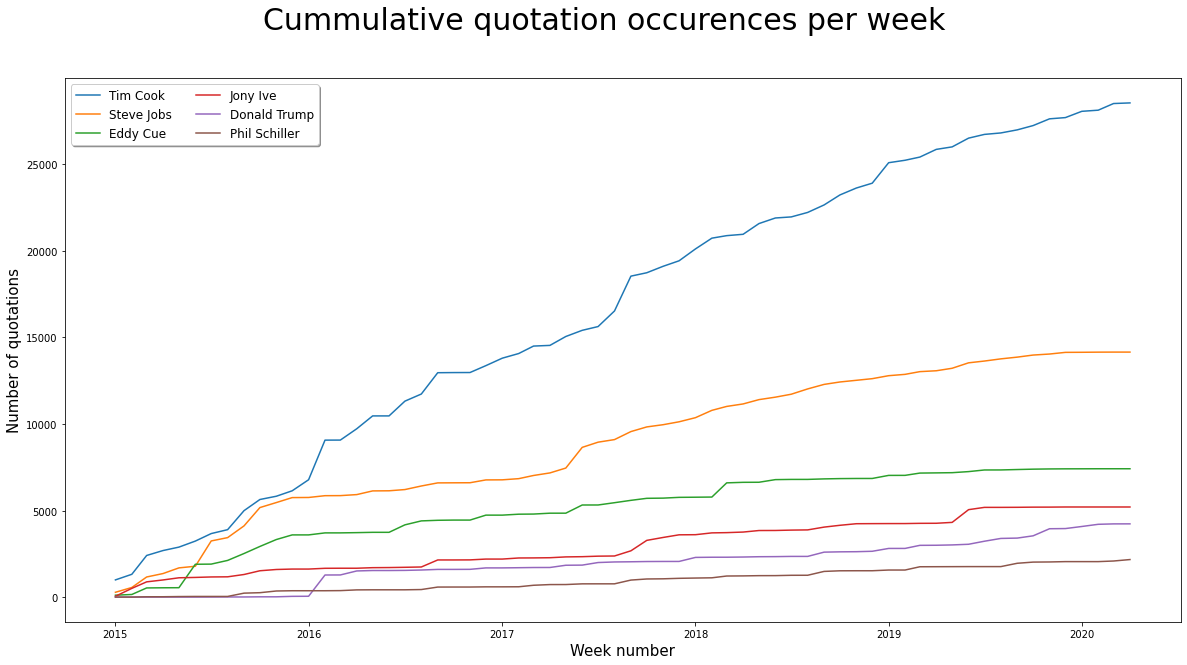

In [15]:
#Extract the 6 most frequent speakers
top_quoters = quotes_per_month.sum(axis=0).nlargest(6).index

#Extracting these from week dataset
top_quotes_per_month = quotes_per_month[top_quoters]
cummulative_top_quotes_per_month = cummulative_quotes_per_month[top_quoters]

fig = plt.figure(figsize=(20, 10))
labels=[]
for quoter in top_quoters:
    plt.plot(cummulative_top_quotes_per_month.index, cummulative_top_quotes_per_month[quoter])
    labels.append(quoter)

plt.legend(labels, ncol=2, loc='upper left', fancybox=True, shadow=True,
           fontsize=12)
fig.suptitle('Cummulative quotation occurences per week', fontsize=30)
plt.xlabel('Week number', fontsize=15)
plt.ylabel('Number of quotations', fontsize=15)



We immediately recognize the big names *Donald Trump*, *Tim Cook* and *Steve Jobs*. Although Steve Jobs has passed away, he frequently gets quoted in the media. In addition, *Jony Ive* is the former chief designer of Apple, whom left the company in 2019. *Eddy Cue* is the senior vice president of Apple, reporting to Tim Cook. So it is natural that these names appear. *Phil Schiller* is also an apple executive. We initially observe that the most frequent speakers of Apple are indeed a part of the company. Not very shocking.

The problem with the plot above is that it only shows the speakers with the most attributed quotes throughout the whole period. To get a more dynamic view over the whole period, we've made an animation which shows the most frequent speakers up to each point in time. This can be viewed in the README.

### Code for making a .mp4 file with the animation

In [16]:
def summary(values, ranks):
    total_quotes = int(round(values.sum(), -2))
    s = f'Total Quotes - {total_quotes:,.0f}'
    return {'x': .99, 'y': .05, 's': s, 'ha': 'right', 'size': 8}

In [17]:
# Determine whether to make mp4 visualization of most quoted speakers. NOTE: To run this code 'bar_chart_race' and 'ffmpeg' needs to be installed in the environment.
create_mp4 = False
if create_mp4:
    quotes_per_date_plot = bcr.bar_chart_race(cummulative_quotes_per_month, filename='quotes_per_date_plot.mp4',
                                          n_bars=10,
                                          filter_column_colors=True,
                                          period_length=1000,
                                          steps_per_period=20,
                                          bar_label_size=7,
                                          tick_label_size=7,
                                          title='Most frequently quoted speakers about Apple',
                                          period_fmt='%B %Y',  
                                          dpi=500,
                                          shared_fontdict={'family' : 'serif', 'color' : 'black', 'size':'8', 'weight': 'normal'},
                                          cmap='dark12',
                                          period_summary_func=summary)

    

---

# Initial analysis of Apple stock and events

Since a huge part of this project will be to compare the quote data with stock data, we will now look at the Apple stock data, events and quarterly earnings for Apple Inc. 
We start by loading in the data sets.

In [18]:
#Load stock data
stock_data=pd.read_csv('./data/AAPL_2015_to_2020_yahoo_finance.csv')
stock_data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.745993,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,24.048859,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,24.051128,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.388378,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.325428,237458000
5,2015-01-09,28.167500,28.312500,27.552500,28.002501,25.352594,214798000
6,2015-01-12,28.150000,28.157499,27.200001,27.312500,24.727892,198603200
7,2015-01-13,27.857500,28.200001,27.227501,27.555000,24.947439,268367600
8,2015-01-14,27.260000,27.622499,27.125000,27.450001,24.852377,195826400
9,2015-01-15,27.500000,27.514999,26.665001,26.705000,24.177876,240056000


In [19]:
#Load quarterly earnings data
quarterly_earnings=pd.read_excel('./data/Earnings_Apple.xlsx')
quarterly_earnings.head(10)

,Symbol,Company,Earnings Date,EPS Estimate,Reported EPS,Surprise(%)
0,AAPL,Apple Inc,"Oct 26, 2022, 5 AMEST",-,-,-
1,AAPL,Apple Inc,"Jul 25, 2022, 5 AMEST",-,-,-
2,AAPL,Apple Inc,"Apr 26, 2022, 5 AMEST",-,-,-
3,AAPL,Apple Inc,"Jan 25, 2022, 5 AMEST",1.88,-,-
4,AAPL,Apple Inc.,"Oct 28, 2021, 12 AMEST",1.24,1.24,+0.32
5,AAPL,Apple Inc.,"Jul 27, 2021, 12 AMEST",1.01,1.3,+29.1
6,AAPL,Apple Inc.,"Apr 28, 2021, 12 AMEST",0.99,1.4,+41.84
7,AAPL,Apple Inc.,"Jan 27, 2021, 12 AMEST",1.41,1.68,+18.98
8,AAPL,Apple Inc.,"Oct 29, 2020, 12 AMEST",0.7,0.73,+4.29
9,AAPL,Apple Inc.,"Jul 30, 2020, 12 AMEST",0.51,0.65,+26.22


We see that the first 8 rows of the `quarterly_earnings` data frame are irrelevant for this study. We, therefore, remove those.
We also observe that the `quarterly_earnings` and `stock_data` have a different format of their Date column. We need to change one of them to be able to compare the two columns.


In [20]:
#Remove the unnecessary rows in the quarterly_earnings
quarterly_earnings=quarterly_earnings.drop(index=[0,1,2,3,4,5,6,7])

#Change the format of the Earnings Date column to be able to compare it with the Stock dataframe
quarterly_earnings["Earnings Date"]=quarterly_earnings["Earnings Date"].map(lambda x: x.replace(", 12 AMEST", "").replace(",", ""))
quarterly_earnings["Earnings Date"]=quarterly_earnings["Earnings Date"].map(lambda x: dt.datetime.strptime(x, "%b %d %Y").strftime("%Y-%m-%d"))

We now create a new dataframe containing only stock data from earning dates.

In [21]:
#Compare Dates in the two dataframe, based on this we create a new dataframe
apple_earnings_and_stock_data=stock_data[stock_data.Date.isin(quarterly_earnings["Earnings Date"])]
apple_earnings_and_stock_data.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume
900,2018-07-31,47.575001,48.035000,47.334999,47.572498,45.860889,157492000
1150,2019-07-30,52.189999,52.540001,51.827499,52.195000,51.083000,135742800
206,2015-10-27,28.850000,29.135000,28.497499,28.637501,26.256874,279537600
715,2017-11-02,41.650002,42.125000,41.320000,42.027500,40.051891,165573600
523,2017-01-31,30.287500,30.347500,30.155001,30.337500,28.556133,196804000


In [22]:
#Create a new dataframe only containing stock data from Apple event-days
apple_event_and_stock_data=stock_data[stock_data.Date.isin(apple_event_dates_str)]
apple_event_and_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
44,2015-03-09,31.990000,32.392502,31.264999,31.785000,28.890726,354114000
109,2015-06-10,31.980000,32.334999,31.962500,32.220001,29.408445,156349200
172,2015-09-09,28.440001,28.504999,27.442499,27.537500,25.248312,340043200
305,2016-03-21,26.482500,26.912500,26.285000,26.477501,24.512644,142010800
365,2016-06-15,24.455000,24.602501,24.257500,24.285000,22.619728,117780800


In [23]:
#Create a new dataframe only containing stock data from Apple event-days
apple_event_and_stock_data=stock_data[stock_data.Date.isin(apple_event_dates_str)]
apple_earnings_and_stock_data=stock_data[stock_data.Date.isin(quarterly_earnings["Earnings Date"])]

## Add data to dates where the stock market is closed

In [24]:
stock_data.head(3) 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.8475,27.860001,26.837500,27.332500,24.745993,212818400
1,2015-01-05,27.0725,27.162500,26.352501,26.562500,24.048859,257142000
2,2015-01-06,26.6350,26.857500,26.157499,26.565001,24.051128,263188400


We see that the `stock_data` don't contain all dates due to bank holidays and weekends. This may create conflicts when we want to merge the quotes dataset with the `stock_data`. We will therefore look into different solutions in solving this problem.
First we try to fill the left out dates with the last valid observation.

In [25]:
# Copy and fill missing dates
stock_data_with_closed_days=stock_data.copy()
idx = pd.date_range('2015-01-02', '2020-12-31')
stock_data_with_closed_days.index = pd.DatetimeIndex(stock_data.Date)
stock_data_with_closed_days = stock_data_with_closed_days.reindex(idx, method='ffill').reset_index()
stock_data_with_closed_days = stock_data_with_closed_days.drop(columns=['Date'])
stock_data_with_closed_days = stock_data_with_closed_days.rename(columns={"index": "Date"})

In [26]:
stock_data_with_closed_days.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.8475,27.860001,26.837500,27.332500,24.745993,212818400
1,2015-01-03,27.8475,27.860001,26.837500,27.332500,24.745993,212818400
2,2015-01-04,27.8475,27.860001,26.837500,27.332500,24.745993,212818400
3,2015-01-05,27.0725,27.162500,26.352501,26.562500,24.048859,257142000
4,2015-01-06,26.6350,26.857500,26.157499,26.565001,24.051128,263188400


We now see that all dates has observations in it.

We can then plot the event dates, quarterly earning dates and stock price to see if there is any correlation between the dates.

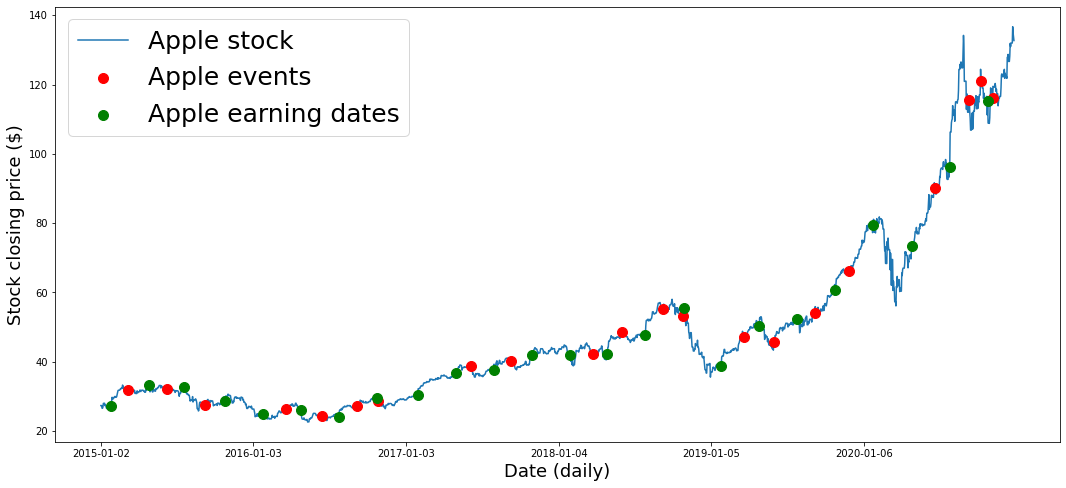

In [27]:
#Plots the dates after adding the 
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(stock_data_with_closed_days.Date,stock_data_with_closed_days.Close, label='Apple stock')
ax.set_xlabel("Date (daily)", size=18)
ax.set_ylabel('Stock closing price ($)', size=18)
plt.xticks(stock_data_with_closed_days.Date[::366])
ax.scatter(apple_event_and_stock_data.Date, apple_event_and_stock_data.Close, c="r", s=100, zorder=3, label='Apple events')
ax.scatter(apple_earnings_and_stock_data.Date, apple_earnings_and_stock_data.Close, c="g", s=100, zorder=3, label='Apple earning dates')
ax.legend(prop={'size': 25})
plt.show()

In addition we plot a graph with the trading volume for each day, to see if there are higher trading volumes around the event and quarterly earning dates.

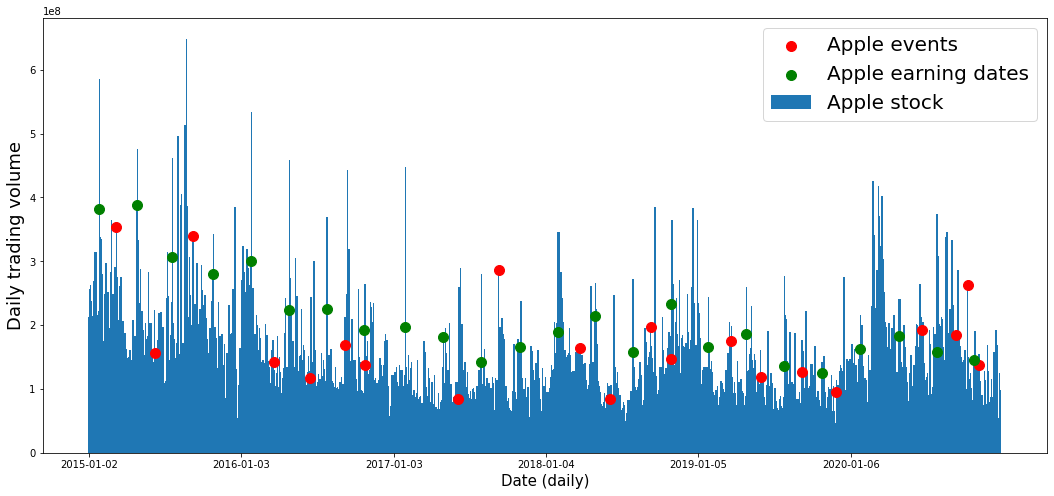

In [28]:
#Plot each trading day and its volume
fig,ax = plt.subplots(figsize=(18,8))
ax.bar(stock_data_with_closed_days.Date,stock_data_with_closed_days.Volume, label='Apple stock', width=3, align='center')
ax.set_xlabel("Date (daily)",size=15)
ax.set_ylabel('Daily trading volume', size=18)
plt.xticks(stock_data_with_closed_days.Date[::366])
ax.scatter(apple_event_and_stock_data.Date, apple_event_and_stock_data.Volume, c="r", s=100, zorder=3, label='Apple events')
ax.scatter(apple_earnings_and_stock_data.Date, apple_earnings_and_stock_data.Volume, c="g", s=100, zorder=3, label='Apple earning dates')
ax.legend(prop={'size': 20})
plt.show()

Interestingly, it seems that some events occur in periods with high trading volume. In milestone 3 we want to investigate how this correlates to the media attention. 

## Group by week

Quote values may fluctuate heavily from day to day, and it is thus reasonable to aggregate in weeks. When comparing quote values to stocks, we thus need to be able to aggregate stock data on a weekly basis. Instead of imputing data into the `stock_data`, we thus try to average the values per week. 

In [29]:
stock_data_weekly_average=stock_data.copy()

#Create a new dataframe containing the weekly average of the stock price. The method is obtained from
stock_data_weekly_average.Date = pd.to_datetime(stock_data_weekly_average.Date) - pd.to_timedelta(7, unit='d')
stock_data_weekly_average = stock_data_weekly_average.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().reset_index().sort_values('Date')
stock_data_weekly_average.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-29,27.46000,27.511251,26.595000,26.947500,24.397426,234980200.0
1,2015-01-05,27.41200,27.683000,26.952000,27.358000,24.769084,214894240.0
2,2015-01-12,27.34375,27.558125,26.829375,27.051875,24.491926,254575800.0
3,2015-01-19,27.65450,28.030500,27.441000,27.837500,25.203208,203481600.0
4,2015-01-26,29.14100,29.448001,28.641500,28.957000,26.216769,378373440.0


We then plot the new graph.

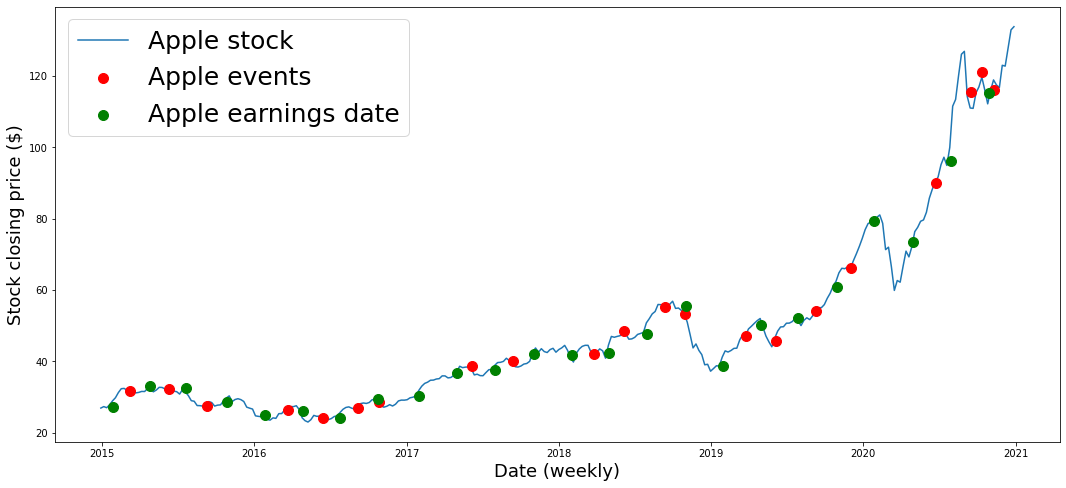

In [30]:
#Plots the weekly average
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(stock_data_weekly_average.Date,stock_data_weekly_average.Close, label='Apple stock')
apple_events=ax.set_xlabel("Date (weekly)",size=18)
ax.set_ylabel('Stock closing price ($)', size=18)
ax.scatter(apple_event_and_stock_data.Date, apple_event_and_stock_data.Close, c="r", s=100, zorder=3, label='Apple events')
ax.scatter(apple_earnings_and_stock_data.Date, apple_earnings_and_stock_data.Close, c="g", s=100, zorder=3, label='Apple earnings date')
ax.legend(prop={'size': 25})
plt.show();